<>:4: SyntaxWarning: invalid escape sequence '\M'
<>:4: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Jspch\AppData\Local\Temp\ipykernel_17636\3025306737.py:4: SyntaxWarning: invalid escape sequence '\M'
  data = pd.read_csv("Data\Merged SPI & NDVI & VPD\Region wise CSV\Channel Country.csv")


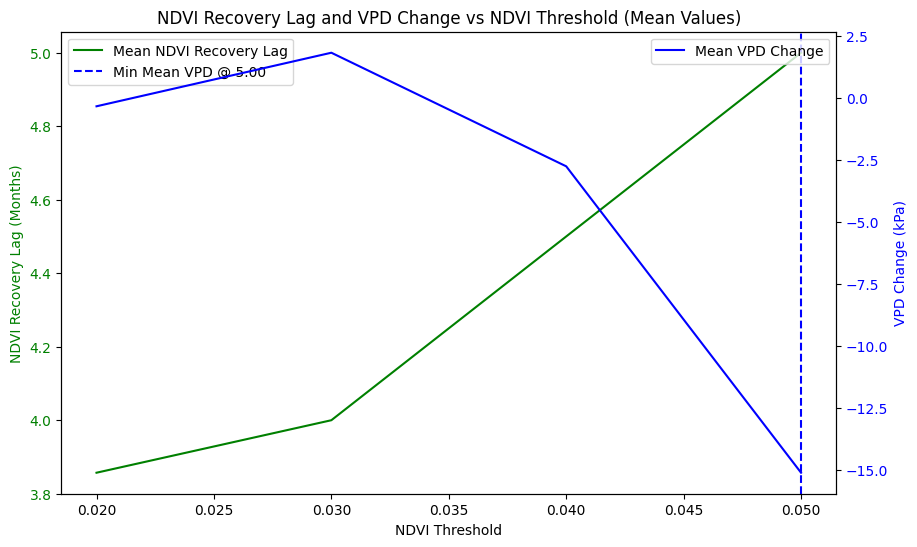

Correlation between NDVI Recovery Lag and VPD Change: 0.26104358507143444


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("Data\Merged SPI & NDVI & VPD\Region wise CSV\Channel Country.csv")

# Example: Define your NDVI threshold range
thresholds = [0.02, 0.03, 0.04, 0.05]

# Initialize a list to store results
all_results = []

# Function to calculate NDVI recovery lag
def calculate_ndvi_recovery_lag(threshold, ndvi, spi):
    recovery_lags = []
    recovery_indices = []
    for i in range(2, len(ndvi) - 6):
        if spi[i - 1] < -1 and spi[i] > -0.5:  # SPI recovery
            ndvi_start = ndvi[i]
            for lag in range(1, 7):  # Look ahead up to 6 months
                if ndvi[i + lag] - ndvi_start >= threshold:
                    recovery_lags.append(lag)
                    recovery_indices.append(i)
                    break
    return recovery_lags, recovery_indices

# Loop through the thresholds
for threshold in thresholds:
    # Get recovery lags and start indices
    recovery_lags, recovery_indices = calculate_ndvi_recovery_lag(threshold, data['NDVI'], data['SPI'])
    
    vpd_changes = []
    for i in range(len(recovery_lags)):
        start_index = recovery_indices[i]
        lag = recovery_lags[i]
        vpd_start = data['VPD'].iloc[start_index]
        vpd_end = data['VPD'].iloc[start_index + lag]
        vpd_change = vpd_end - vpd_start
        vpd_changes.append(vpd_change)
        
        # print(f"Threshold: {threshold}, Lag: {lag}, VPD Change: {vpd_change}")

        # Store the result
        all_results.append({
            'Threshold': threshold,
            'NDVI Recovery Lag (Months)': lag,
            'VPD Change (kPa)': vpd_change
        })

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)

# Group by threshold to get mean VPD Change and NDVI Lag
mean_df = results_df.groupby('Threshold', as_index=False).mean()

# Plot the mean values instead
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.lineplot(data=mean_df, x="Threshold", y="NDVI Recovery Lag (Months)", ax=ax1, color='green', label='Mean NDVI Recovery Lag')
ax1.set_ylabel('NDVI Recovery Lag (Months)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
sns.lineplot(data=mean_df, x="Threshold", y="VPD Change (kPa)", ax=ax2, color='blue', label='Mean VPD Change')
ax2.set_ylabel('VPD Change (kPa)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# recovery_Lags at NDVI threshold 0.05
NDVI_t = 0.05
recovery_lags = results_df.loc[results_df['Threshold'] == NDVI_t, 'NDVI Recovery Lag (Months)'].mean()

# Add vertical line at the threshold with lowest mean VPD change
min_mean_vpd_threshold = mean_df.loc[mean_df['VPD Change (kPa)'].idxmin(), 'Threshold']
min_mean_vpd = mean_df['VPD Change (kPa)'].min()
ax1.axvline(x=min_mean_vpd_threshold, color='blue', linestyle='--', label=f'Min Mean VPD @ {recovery_lags:.2f}')
ax1.legend(loc='upper left')

plt.title('NDVI Recovery Lag and VPD Change vs NDVI Threshold (Mean Values)')
ax1.set_xlabel('NDVI Threshold')
plt.show()

# Correlation between NDVI Recovery Lag and VPD Change
correlation = results_df['NDVI Recovery Lag (Months)'].corr(results_df['VPD Change (kPa)'])
print(f"Correlation between NDVI Recovery Lag and VPD Change: {correlation}")

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def process_region(file_path, thresholds=[0.02, 0.03, 0.04, 0.05], plot=True):
    data = pd.read_csv(file_path)

    all_results = []

    # Function to calculate NDVI recovery lag
    def calculate_ndvi_recovery_lag(threshold, ndvi, spi):
        recovery_lags = []
        recovery_indices = []
        for i in range(2, len(ndvi) - 6):
            if spi[i - 1] < -1 and spi[i] > -0.5:
                ndvi_start = ndvi[i]
                for lag in range(1, 7):
                    if i + lag < len(ndvi) and ndvi[i + lag] - ndvi_start >= threshold:
                        recovery_lags.append(lag)
                        recovery_indices.append(i)
                        break
        return recovery_lags, recovery_indices

    for threshold in thresholds:
        recovery_lags, recovery_indices = calculate_ndvi_recovery_lag(threshold, data['NDVI'], data['SPI'])

        vpd_changes = []
        for i in range(len(recovery_lags)):
            start_index = recovery_indices[i]
            lag = recovery_lags[i]
            vpd_start = data['VPD'].iloc[start_index]
            vpd_end = data['VPD'].iloc[start_index + lag]
            vpd_changes.append(vpd_end - vpd_start)

            all_results.append({
                'Threshold': threshold,
                'NDVI Recovery Lag (Months)': lag,
                'VPD Change (kPa)': vpd_end - vpd_start,
                'VPD End (kPa)': vpd_end,
            })

        # print(f"Threshold {threshold}: {len(recovery_lags)} recovery events")

    results_df = pd.DataFrame(all_results)
    mean_df = results_df.groupby('Threshold', as_index=False).mean()

    # Identify best threshold
    min_mean_vpd_threshold = mean_df.loc[mean_df['VPD End (kPa)'].idxmin(), 'Threshold']
    best_recovery_lag = results_df.loc[results_df['Threshold'] == min_mean_vpd_threshold, 'NDVI Recovery Lag (Months)'].mean()
    correlation = results_df['NDVI Recovery Lag (Months)'].corr(results_df['VPD End (kPa)'])

    # Plot
    if plot:
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Gridlines for x-axis
        ax1.set_xticks(thresholds)
        ax1.grid(True, which='major', axis='x', linestyle='--', color='gray', alpha=0.5)
        

        # First: plot a "glow" line behind the main line (slightly thicker and transparent)
        sns.lineplot(data=mean_df, x="Threshold", y="NDVI Recovery Lag (Months)", ax=ax1,
             color='grey', linewidth=20, alpha=0.05)

        sns.lineplot(data=mean_df, x="Threshold", y="NDVI Recovery Lag (Months)", ax=ax1, color='green', label='Mean NDVI Recovery Lag', marker='s')
        ax1.set_ylabel('NDVI Recovery Lag (Months)', color='green')
        ax1.tick_params(axis='y', labelcolor='green')

        for x, y in zip(mean_df['Threshold'], mean_df['NDVI Recovery Lag (Months)']):
            ax1.text(x, y + 0.05, f'{y:.2f}', color='green', fontsize=9, ha='center')

        # Gridlines for y-axis
        # ax1.set_yticks([0, 1, 2, 3, 4, 5, 6])
        # ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6])
        # ax1.set_ylim(0, 6)
        # ax1.grid(True, which='major', axis='y', linestyle='--', color='gray', alpha=0.3)
        

        ax2 = ax1.twinx()

        # Gridlines for y-axis
        # ax2.set_yticks([0, 1, 2, 3, 4, 5])
        # ax2.set_yticklabels([0, 1, 2, 3, 4, 5])
        # ax2.set_ylim(0, 5)
        ax2.grid(True, which='major', axis='y', linestyle='--', color='gray', alpha=0.5)

        # Remove top and right spines (borders)
        for spine in ['top', 'right']:
            ax1.spines[spine].set_visible(False)
            ax2.spines[spine].set_visible(False)

        # Glow line behind VPD line
        sns.lineplot(data=mean_df, x="Threshold", y="VPD End (kPa)", ax=ax2,
             color='red', linewidth=20, alpha=0.05)

        sns.lineplot(data=mean_df, x="Threshold", y="VPD End (kPa)", ax=ax2, color='red', label='Mean VPD', marker='o')
        ax2.set_ylabel('VPD (kPa)', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        for x, y in zip(mean_df['Threshold'], mean_df['VPD End (kPa)']):
            ax2.text(x, y - 0.05, f'{y:.2f}', color='red', fontsize=9, ha='center')

        ax1.axvline(x=min_mean_vpd_threshold, color='orange', linestyle='--', label=f'Min Mean VPD at {best_recovery_lag:.2f} months')
        ax1.legend(loc='upper left')
        # plt.title(f'NDVI Recovery Lag and VPD Change vs NDVI Threshold\n{os.path.basename(file_path).replace(".csv", "")}')
        plt.title(f'{os.path.basename(file_path).replace(".csv", "")}')
        ax1.set_xlabel('NDVI Threshold')
        # ax1.set_xticklabels([f"{x:.2f}" for x in [0.02, 0.03, 0.04, 0.05]])
        ax1.set_xticks([0.02, 0.03, 0.04, 0.05])
        # plt.tight_layout()
        # plt.show()

    return {
        'Region': os.path.basename(file_path).replace('.csv', ''),
        'Best Threshold': min_mean_vpd_threshold,
        'Mean NDVI Recovery Lag': best_recovery_lag,
        'Recovery events total': len(recovery_lags),
        'Correlation': correlation
    }


In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def process_region(file_path, thresholds=[0.02, 0.03, 0.04, 0.05], plot=True):
    data = pd.read_csv(file_path)

    all_results = []

    def calculate_ndvi_recovery_lag(threshold, ndvi, spi):
        recovery_lags = []
        recovery_indices = []
        for i in range(2, len(ndvi) - 6):
            if spi[i - 1] < -1 and spi[i] > -0.5:
                ndvi_start = ndvi[i]
                for lag in range(1, 7):
                    if i + lag < len(ndvi) and ndvi[i + lag] - ndvi_start >= threshold:
                        recovery_lags.append(lag)
                        recovery_indices.append(i)
                        break
        return recovery_lags, recovery_indices

    for threshold in thresholds:
        recovery_lags, recovery_indices = calculate_ndvi_recovery_lag(threshold, data['NDVI'], data['SPI'])
        for i in range(len(recovery_lags)):
            start_index = recovery_indices[i]
            lag = recovery_lags[i]
            vpd_start = data['VPD'].iloc[start_index]
            vpd_end = data['VPD'].iloc[start_index + lag]
            all_results.append({
                'Threshold': threshold,
                'NDVI Recovery Lag (Months)': lag,
                'VPD Change (kPa)': vpd_end - vpd_start
            })

    results_df = pd.DataFrame(all_results)
    mean_df = results_df.groupby('Threshold', as_index=False).mean()

    min_mean_vpd_threshold = mean_df.loc[mean_df['VPD Change (kPa)'].idxmin(), 'Threshold']
    best_recovery_lag = results_df.loc[results_df['Threshold'] == min_mean_vpd_threshold, 'NDVI Recovery Lag (Months)'].mean()
    correlation = results_df['NDVI Recovery Lag (Months)'].corr(results_df['VPD Change (kPa)'])

    if plot:
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Clean up borders
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)

        # Gridlines on vertical thresholds
        ax1.set_xticks(thresholds)
        ax1.grid(True, which='major', axis='x', linestyle='--', color='gray', alpha=0.3)

        # Plot NDVI Recovery Lag (green)
        ax1.plot(mean_df['Threshold'], mean_df['NDVI Recovery Lag (Months)'], color='green', linewidth=12, alpha=0.15)
        ax1.plot(mean_df['Threshold'], mean_df['NDVI Recovery Lag (Months)'], color='green', marker='s', label='NDVI Recovery Lag')
        ax1.set_ylabel('NDVI Recovery Lag (Months)', color='green')
        ax1.tick_params(axis='y', labelcolor='green')

        for x, y in zip(mean_df['Threshold'], mean_df['NDVI Recovery Lag (Months)']):
            ax1.text(x, y + 0.05, f'{y:.2f}', color='green', fontsize=9, ha='center')

        # Plot VPD Change (blue) on secondary axis
        ax2 = ax1.twinx()
        ax2.plot(mean_df['Threshold'], mean_df['VPD Change (kPa)'], color='blue', linewidth=12, alpha=0.15)
        ax2.plot(mean_df['Threshold'], mean_df['VPD Change (kPa)'], color='blue', marker='o', label='VPD Change')
        ax2.set_ylabel('VPD Change (kPa)', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')

        for x, y in zip(mean_df['Threshold'], mean_df['VPD Change (kPa)']):
            ax2.text(x, y - 0.05, f'{y:.2f}', color='blue', fontsize=9, ha='center')

        # Highlight threshold with lowest mean VPD change
        ax1.axvline(x=min_mean_vpd_threshold, color='orange', linestyle='--', label=f'Min VPD @ {best_recovery_lag:.2f}m')

        ax1.set_xlabel('NDVI Threshold')
        ax1.legend(loc='upper left')
        plt.title(os.path.basename(file_path).replace('.csv', ''))
        plt.tight_layout()
        plt.show()

    return {
        'Region': os.path.basename(file_path).replace('.csv', ''),
        'Best Threshold': min_mean_vpd_threshold,
        'Mean NDVI Recovery Lag': best_recovery_lag,
        'Correlation': correlation
    }


                      Region  Best Threshold  Mean NDVI Recovery Lag  \
0              Brigalow Belt            0.02                3.176471   
1        Cape York Peninsula            0.05                2.800000   
2   Central Queensland Coast            0.05                3.294118   
3            Channel Country            0.05                5.000000   
4             Desert Uplands            0.05                4.000000   
5         Einasleigh Uplands            0.05                2.909091   
6                Gulf Plains            0.04                2.400000   
7       Mitchell Grass Downs            0.05                3.636364   
8                Mulga Lands            0.04                3.727273   
9      New England Tableland            0.04                3.142857   
10       Northwest Highlands            0.05                4.250000   
11      Southeast Queensland            0.05                3.117647   
12               Wet Tropics            0.04                2.53

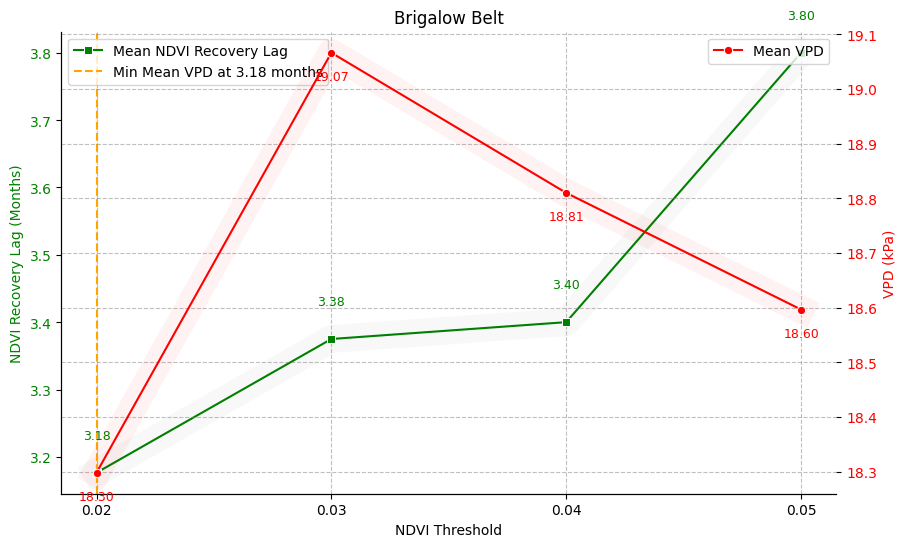

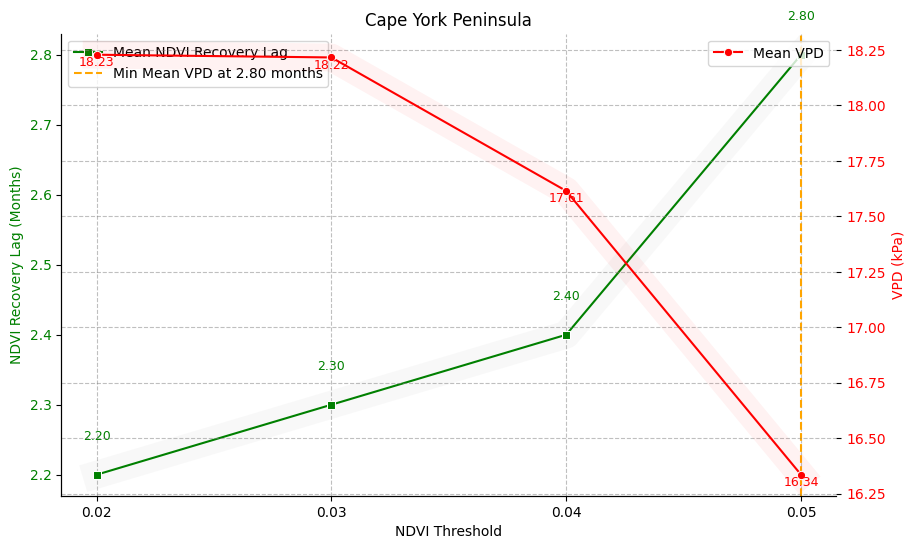

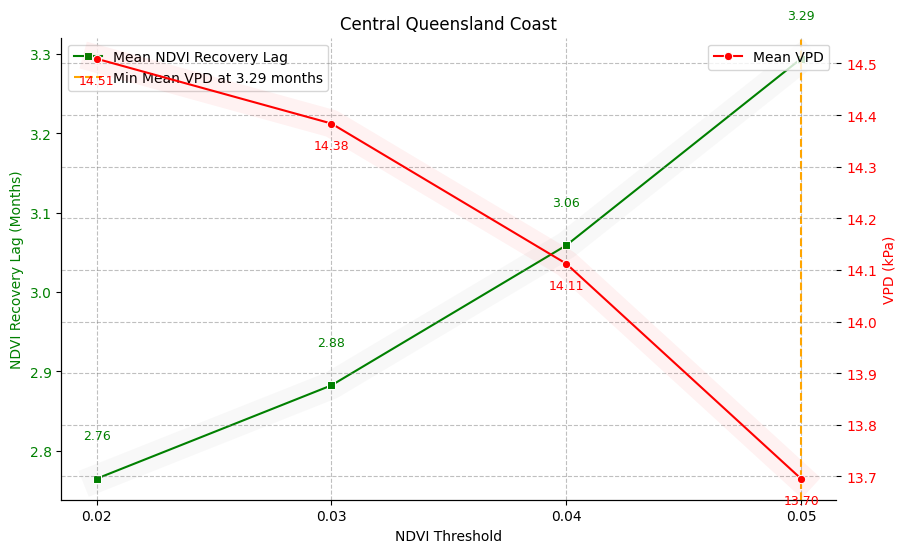

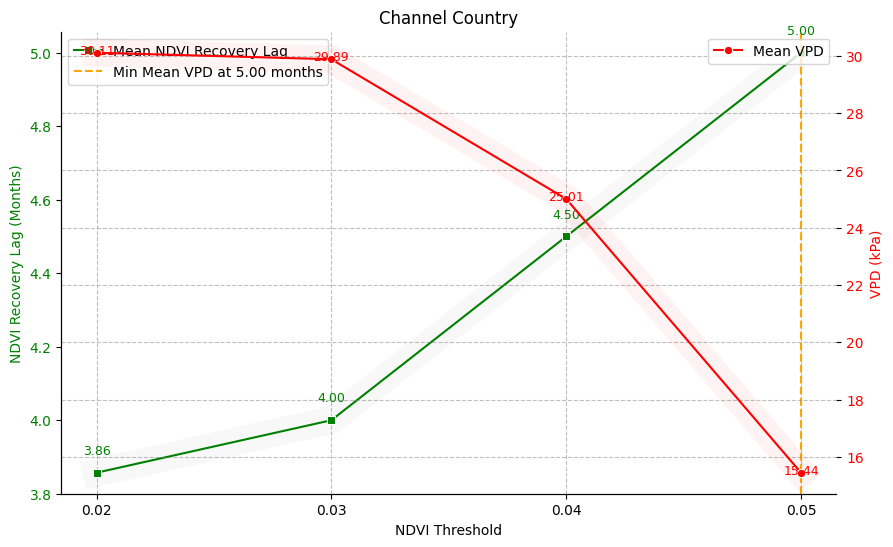

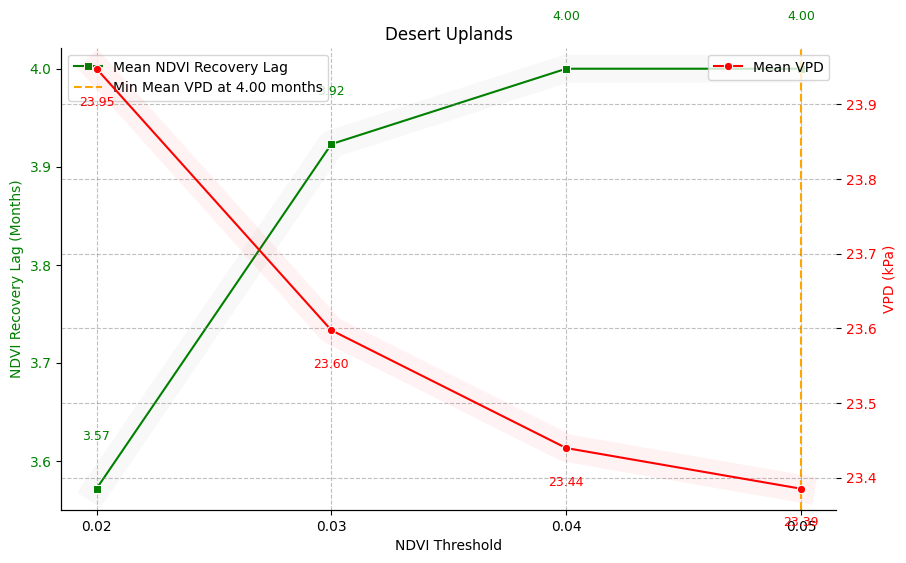

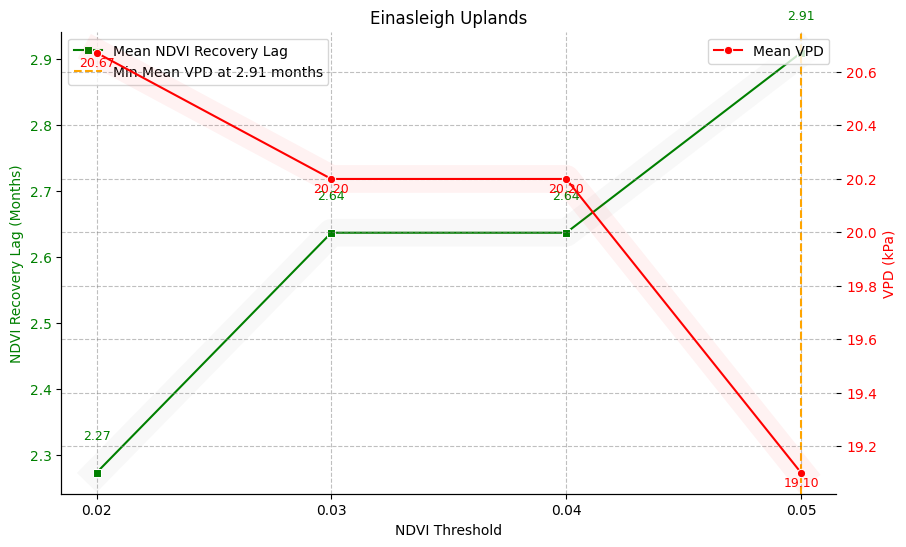

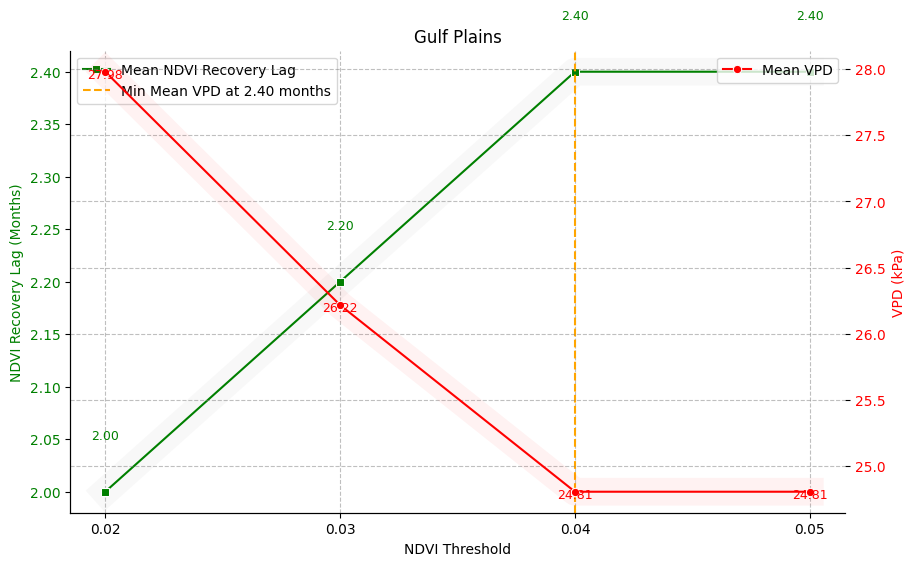

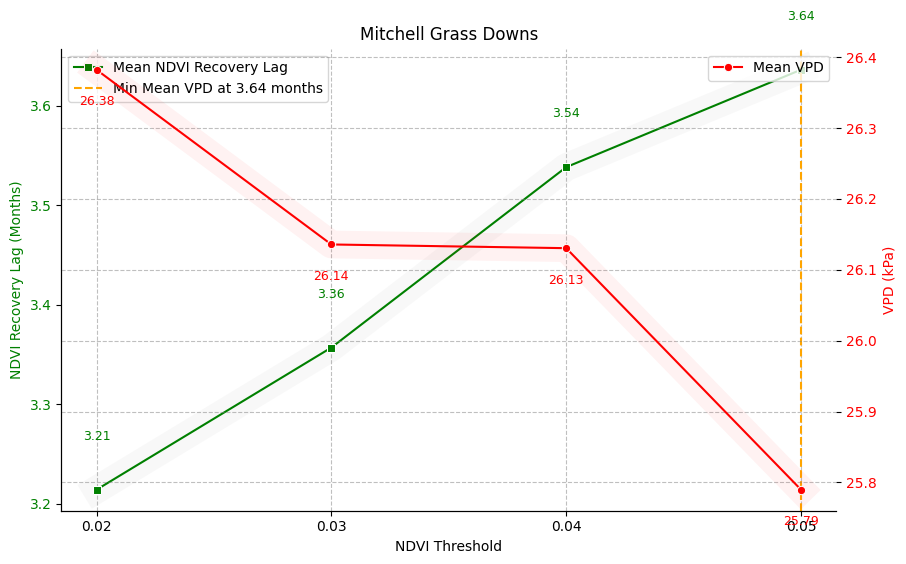

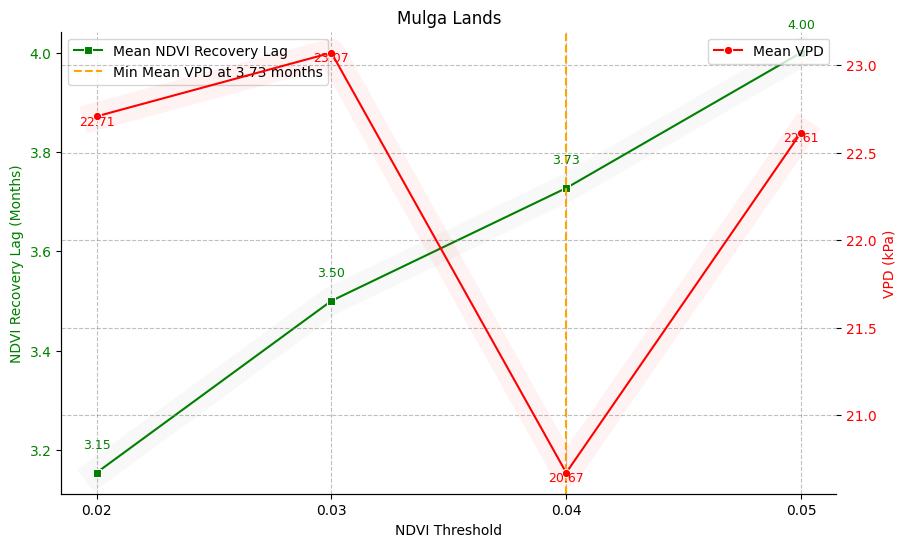

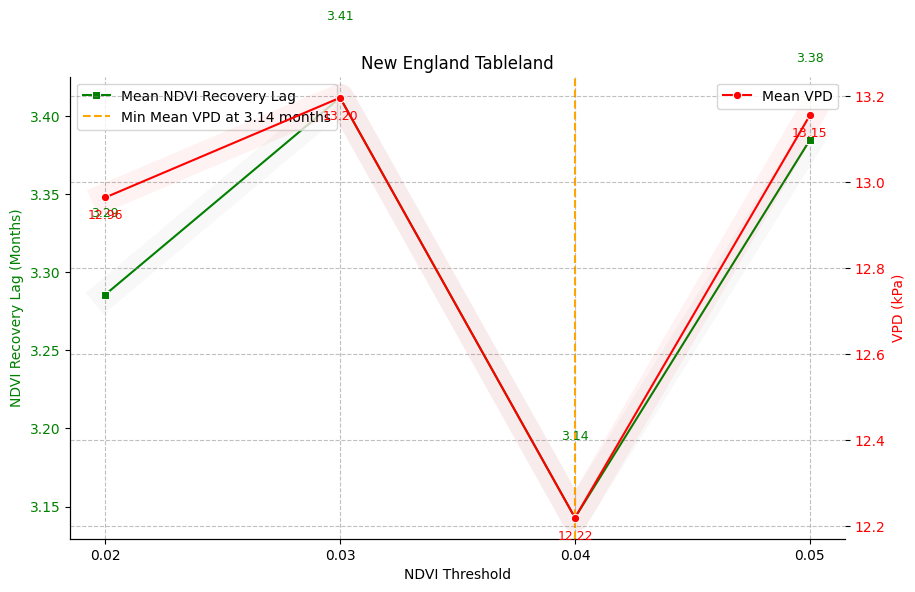

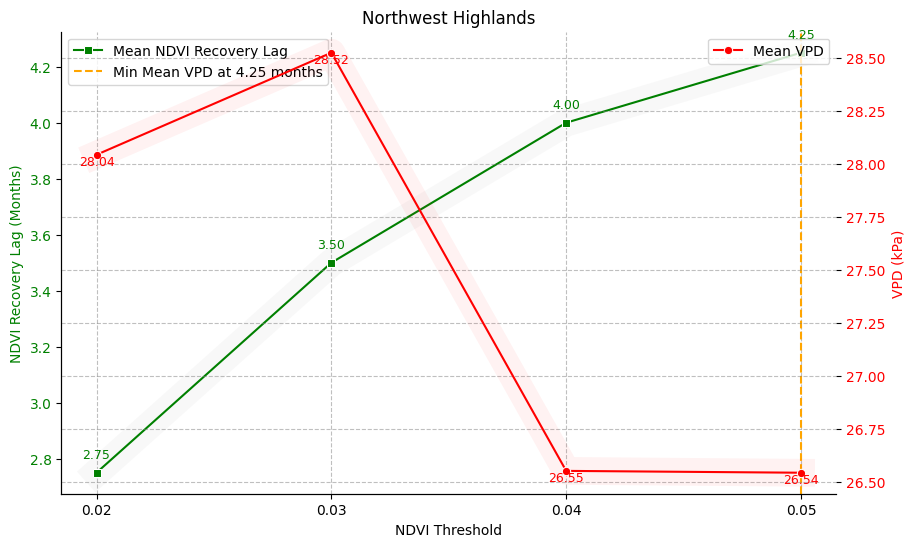

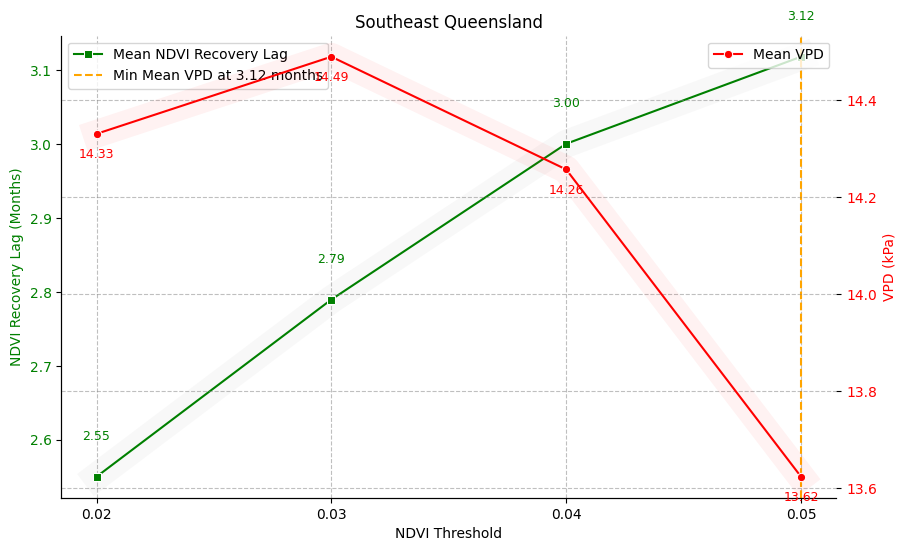

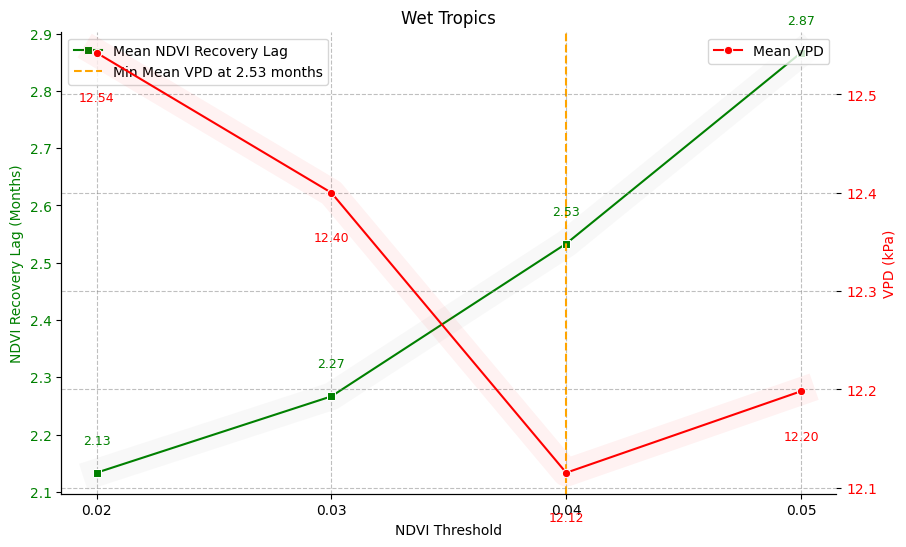

In [14]:
import glob

results = []
csv_files = glob.glob("Data/Merged SPI & NDVI & VPD/Region wise CSV/*.csv")

for file in csv_files:
    result = process_region(file)
    results.append(result)

summary_df = pd.DataFrame(results)
print(summary_df)


In [15]:
import os

# Save the summary DataFrame to a CSV file
summary_df.to_csv(r"Figures\Figures for Paper\NDVI vs VPD\summary_results.csv")

# Directory to save the figures
output_dir = r"Figures\Figures for Paper\NDVI vs VPD"
os.makedirs(output_dir, exist_ok=True)

# Save each figure with the region name
for file in csv_files:
    region_name = os.path.basename(file).replace('.csv', '')
    result = process_region(file, plot=True)
    
    # Save the figure
    fig_path = os.path.join(output_dir, f"{region_name}.png")
    plt.savefig(fig_path)
    plt.close()  # Close the figure to free memory